# Testing how to get a GeoPandas dataframe of the areas of CWV>55 from contourf

The basic object is [GeoPandas dataframes](https://geopandas.org/getting_started/introduction.html): 

![geopandas dataframe tableau](https://geopandas.org/_images/dataframe.svg "GeoPandas dataframe schema")

The `geometry` column contains shapely objects (polygons which may have holes), areas where CWV>55. Data columns can be anything -- area, rainrate from another dataset, or the ID tags of  active CCVLs (coast-crossing vapor lakes), of which each holey polygon is a part. A given polygon can be tagged as part of multiple CCVLs (having a notnull() entry in multiple data columns), because physically it may be destined to split into parts that will each separately cross the coast. 

In [339]:
!date

Wed Jun  9 18:53:30 MDT 2021


In [1]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os,json           # json just a convenient way to dump some numbers (contour levels)
#from descartes.patch import PolygonPatch

from glob import glob
import xarray as xr
#import dask.array as da

import geopandas as gp

In [6]:
files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one

cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))
lon = cwv_WEIO.lon
lat = cwv_WEIO.lat
tqv = cwv_WEIO.TQV[0].values

In [59]:
str(cwv_WEIO.time[0].values)

'2014-05-15T00:00:00.000000000'

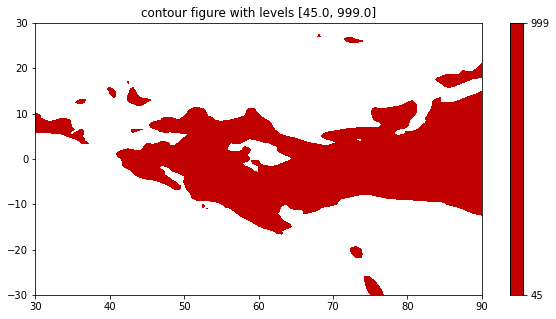

In [329]:
# make the contourf plot, storing the resulting ContourSet in cs
plt.figure(figsize=[10,5])
# Nlevels=3
#levels = [ 30., 40., 50., 60.]
#levels = [45., 50., 55., 60.]
levels = [45., 999.]
cs = plt.contourf(lon,lat,tqv,levels,cmap='gist_heat')
plt.title('contour figure with levels '+ str(levels))
plt.colorbar()

# create lookup table for levels
lvl_lookup = dict(zip(cs.collections, cs.levels))

In [335]:
# loop over collections (and polygons in each collection), store in polylist 
levels, polylist  = [], []
i=0
for col in cs.collections:
    z=lvl_lookup[col] # the value of this level
    for contour_path in col.get_paths():
        print('contour path: ',i); i = i+1
        # create the polygon for this level
        for ncp,cp in enumerate(contour_path.to_polygons()):
            print('   ncp: ', ncp)
            lons = np.array(cp)[:,0]
            lats = np.array(cp)[:,1]
            new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
            if ncp == 0:
                poly = new_shape # first shape
            else:
                poly = poly.difference(new_shape) # Remove the holes
#        PolyList.append({'poly':poly}) #,'props':{'z': z}})
        polylist.append(poly) #,'props':{'z': z}})

        levels.append(z)

contour path:  0
   ncp:  0
contour path:  1
   ncp:  0
contour path:  2
   ncp:  0
   ncp:  1
   ncp:  2
   ncp:  3
   ncp:  4
   ncp:  5
contour path:  3
   ncp:  0
contour path:  4
   ncp:  0
contour path:  5
   ncp:  0
contour path:  6
   ncp:  0
contour path:  7
   ncp:  0
contour path:  8
   ncp:  0
contour path:  9
   ncp:  0
contour path:  10
   ncp:  0
contour path:  11
   ncp:  0
contour path:  12
   ncp:  0
contour path:  13
   ncp:  0


In [338]:
gdf = GeoDataFrame(geometry=polylist_nodict)
gdf['date']=str(cwv_WEIO.time[0].values)
gdf['CWV']=levels
gdf['area']=gdf.area
gdf

,geometry,date,CWV,area
0,"POLYGON ((75.00000 -29.81981, 75.09288 -30.000...",2014-05-15T00:00:00.000000000,45.0,5.989391
1,"POLYGON ((73.12500 -21.75559, 73.75000 -21.788...",2014-05-15T00:00:00.000000000,45.0,2.809003
2,"POLYGON ((61.25000 -15.53873, 61.17523 -15.500...",2014-05-15T00:00:00.000000000,45.0,811.612962
3,"POLYGON ((53.12500 -11.05794, 53.18909 -11.000...",2014-05-15T00:00:00.000000000,45.0,0.013447
4,"POLYGON ((52.50000 -10.68851, 52.78975 -10.500...",2014-05-15T00:00:00.000000000,45.0,0.113020
5,"POLYGON ((36.25000 3.43496, 36.87500 3.34424, ...",2014-05-15T00:00:00.000000000,45.0,19.162476
6,"POLYGON ((43.12500 5.91484, 43.48023 6.00000, ...",2014-05-15T00:00:00.000000000,45.0,0.511349
7,"POLYGON ((43.75000 11.69578, 44.37500 11.91763...",2014-05-15T00:00:00.000000000,45.0,5.693805
8,"POLYGON ((35.62500 12.29523, 36.25000 12.16750...",2014-05-15T00:00:00.000000000,45.0,0.794567
9,"POLYGON ((40.62500 13.47382, 40.65782 13.50000...",2014-05-15T00:00:00.000000000,45.0,1.295348


<AxesSubplot:>

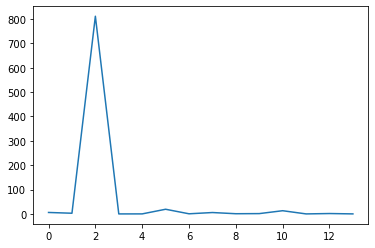

In [324]:
gdf.area.plot()

In [325]:
bigone = gdf[2:3].geometry
print(bigone)

2    POLYGON ((61.25000 -15.53873, 61.17523 -15.500...
Name: geometry, dtype: geometry


<AxesSubplot:>

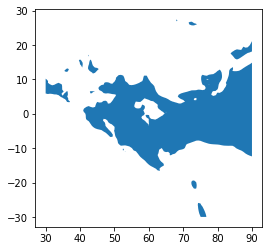

In [327]:
gdf[(gdf.CWV == 45)][:].plot()

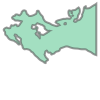

In [336]:
bigboy = polylist_nodict[2:3][0]
bigboy

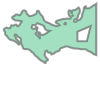

In [337]:
# learn about cutting holes 
interior = [(80,-5), (85,-5), (87,3), (80,0)]
bigboy.difference(geometry.Polygon(interior))

<AxesSubplot:>

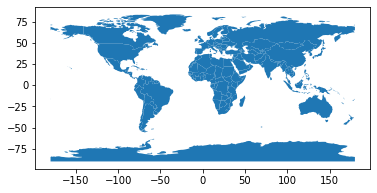

In [341]:
path = gp.datasets.get_path('naturalearth_lowres')
mapdf = gp.read_file(path)
mapdf.plot()

In [343]:
gp.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

<AxesSubplot:>

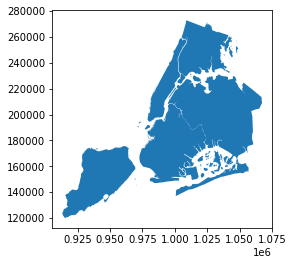

In [345]:
path = gp.datasets.get_path('nybb') # New York boroughs 
mapdf = gp.read_file(path)
mapdf.plot()